# Training DCGAN

**By**: `Alex Andonian`

## Introduction

This tutorial will give a brief introduction to training Generative Adversarial Networks (GANs), which have seen tremendous progress in their short 5 year lifespan. **Fun Fact:** GANs celebrate their 5th anniversary on May 26, 2019. The rapid progress of GANs' sucess in image synthesis is particularly impressive:


In light of the enormous volume of work devoted to GANs, it is nearly impossible to cover everything. Instead, we will start at the beginning with **DCGANs**, which set the stage for the success we are seeing today.


## Preliminaries
First, let's import the all of the  python packages we will use throughout the tutorial. In addition to standard import and PyTorch, we provide a small package called `ganocracy`, which aggregates a host of useful GAN specific functions and utilities in one place - a "one-stop-shop" for everything needed to get started with GANs. 

Almost all code shown in this notebook can be found inside the `ganocracy` package. We house reference implementations outside of the notebook so that bits and pieces can be conveniently incorporated into other projects, (without having to copy and paste from this notebook).

In [1]:
# IMPORTS
import os 
import sys
import numpy as np
import random
from PIL import Image


# PYTORCH
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# GANOCRACY LIB
import ganocracy
from ganocracy.data import datasets as dset
from ganocracy.data import transforms
from ganocracy import metrics, models
from ganocracy.models import utils as mutils
from ganocracy.utils import visualizer as vutils

# NOTEBOOK-SPECIFIC IMPORTS
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Video
try:
    import moviepy.editor as mpy
except ImportError:
    print('WARNING: Could not import moviepy. Some cells may not work.')
    print('You can install it with `pip install moviepy`')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
    
# Set random seem for reproducibility.
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Use this command to make a subset of
# GPUS visible to the jupyter notebook.
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'

In [2]:
dataroot = "data"            # Root directory for the dataset.
dataset_name = 'CelebA'      # Name of dataset.

# Use standard number of classes
# for chosen of dataset.
n_classes = {
    'CelebA': 1,
    'CIFAR10': 10,
    'CIFAR100': 100,
    'ImageNet': 1000,
}.get(dataset_name, 1)

num_workers = 12  # Number of workers for dataloader
batch_size = 256  # Batch size per forward/backward pass.
download = True   # If data is not found, download and cache it.
split = 'train'   # Dataset split (train or val), if applicable.

resolution = 64  # Spatial size of training images. Resized if needed.

dim_z = 100 # Size of z latent vector (i.e. size of generator input)
G_ch = 64   # Channel multiplier - scales number of features per conv in G and D
D_ch = 64

num_epochs = 200 # Number of training epochs

G_lr = 2e-4      # Learning rate for optimizers
D_lr = 2e-4

num_D_steps = 1
num_D_accumulations = 1
num_G_accumulations = 1

D_batch_size = batch_size * num_D_steps * num_D_accumulations

# Betas hyperparams for Adam optimizers
G_betas = (0.5, 0.999)
D_betas = (0.5, 0.999)

ngpu = 2 # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

test_every = 500   # How frequently to evaluate our model. Use 0 to skip testing.
sample_every = 100 # How frequently we save fixed noise samples.

name = 'dev_ema_cDCGAN'    # Experiment specific prefix.
model_dir = 'checkpoints'  # Directory to store model checkpoints.
samples_dir = 'samples'    # Directory to store samples.

TRAIN = True
LOAD_PRETRAINED = False

# Generate model name based on config.
model_name = '_'.join(map(str, [
    name,
    dataset_name, 
    resolution,
    'bs{}'.format(batch_size),
    'dim_z{}'.format(dim_z),
    'G_ch{}'.format(G_ch),
    'D_ch{}'.format(D_ch),
    'G_lr{}'.format(G_lr),
    'D_lr{}'.format(D_lr),
    'G_betas{}'.format('_'.join(map(str, G_betas))),
    'D_betas{}'.format('_'.join(map(str, D_betas))),
]))


save_name = os.path.join(model_dir, model_name + '.pth.tar')
os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)
os.makedirs(os.path.join(samples_dir, model_name), exist_ok=True)
print(f'Starting experiment {model_name}')

Starting experiment dev_ema_cDCGAN_CelebA_64_bs256_dim_z100_G_ch64_D_ch64_G_lr0.0002_D_lr0.0002_G_betas0.5_0.999_D_betas0.5_0.999


## Data Preparation
In this tutorial, we will use the CelebFaces Attributes Dataset (CelebA), a large-scale face attributes dataset with more than 200K celebrity images. Each image is annotated with 40 attributes (e.g. smiling, eyeglasses, etc.). 

We can download this dataset (along with a host of other commonly used datasets) with PyTorch's [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) package. Support for downloadng an number of new datasets was just added in version 0.3.0!

Files already downloaded and verified
Dataset CelebA
    Number of datapoints: 162770
    Root location: data
    Target type: ['attr']
    Split: train


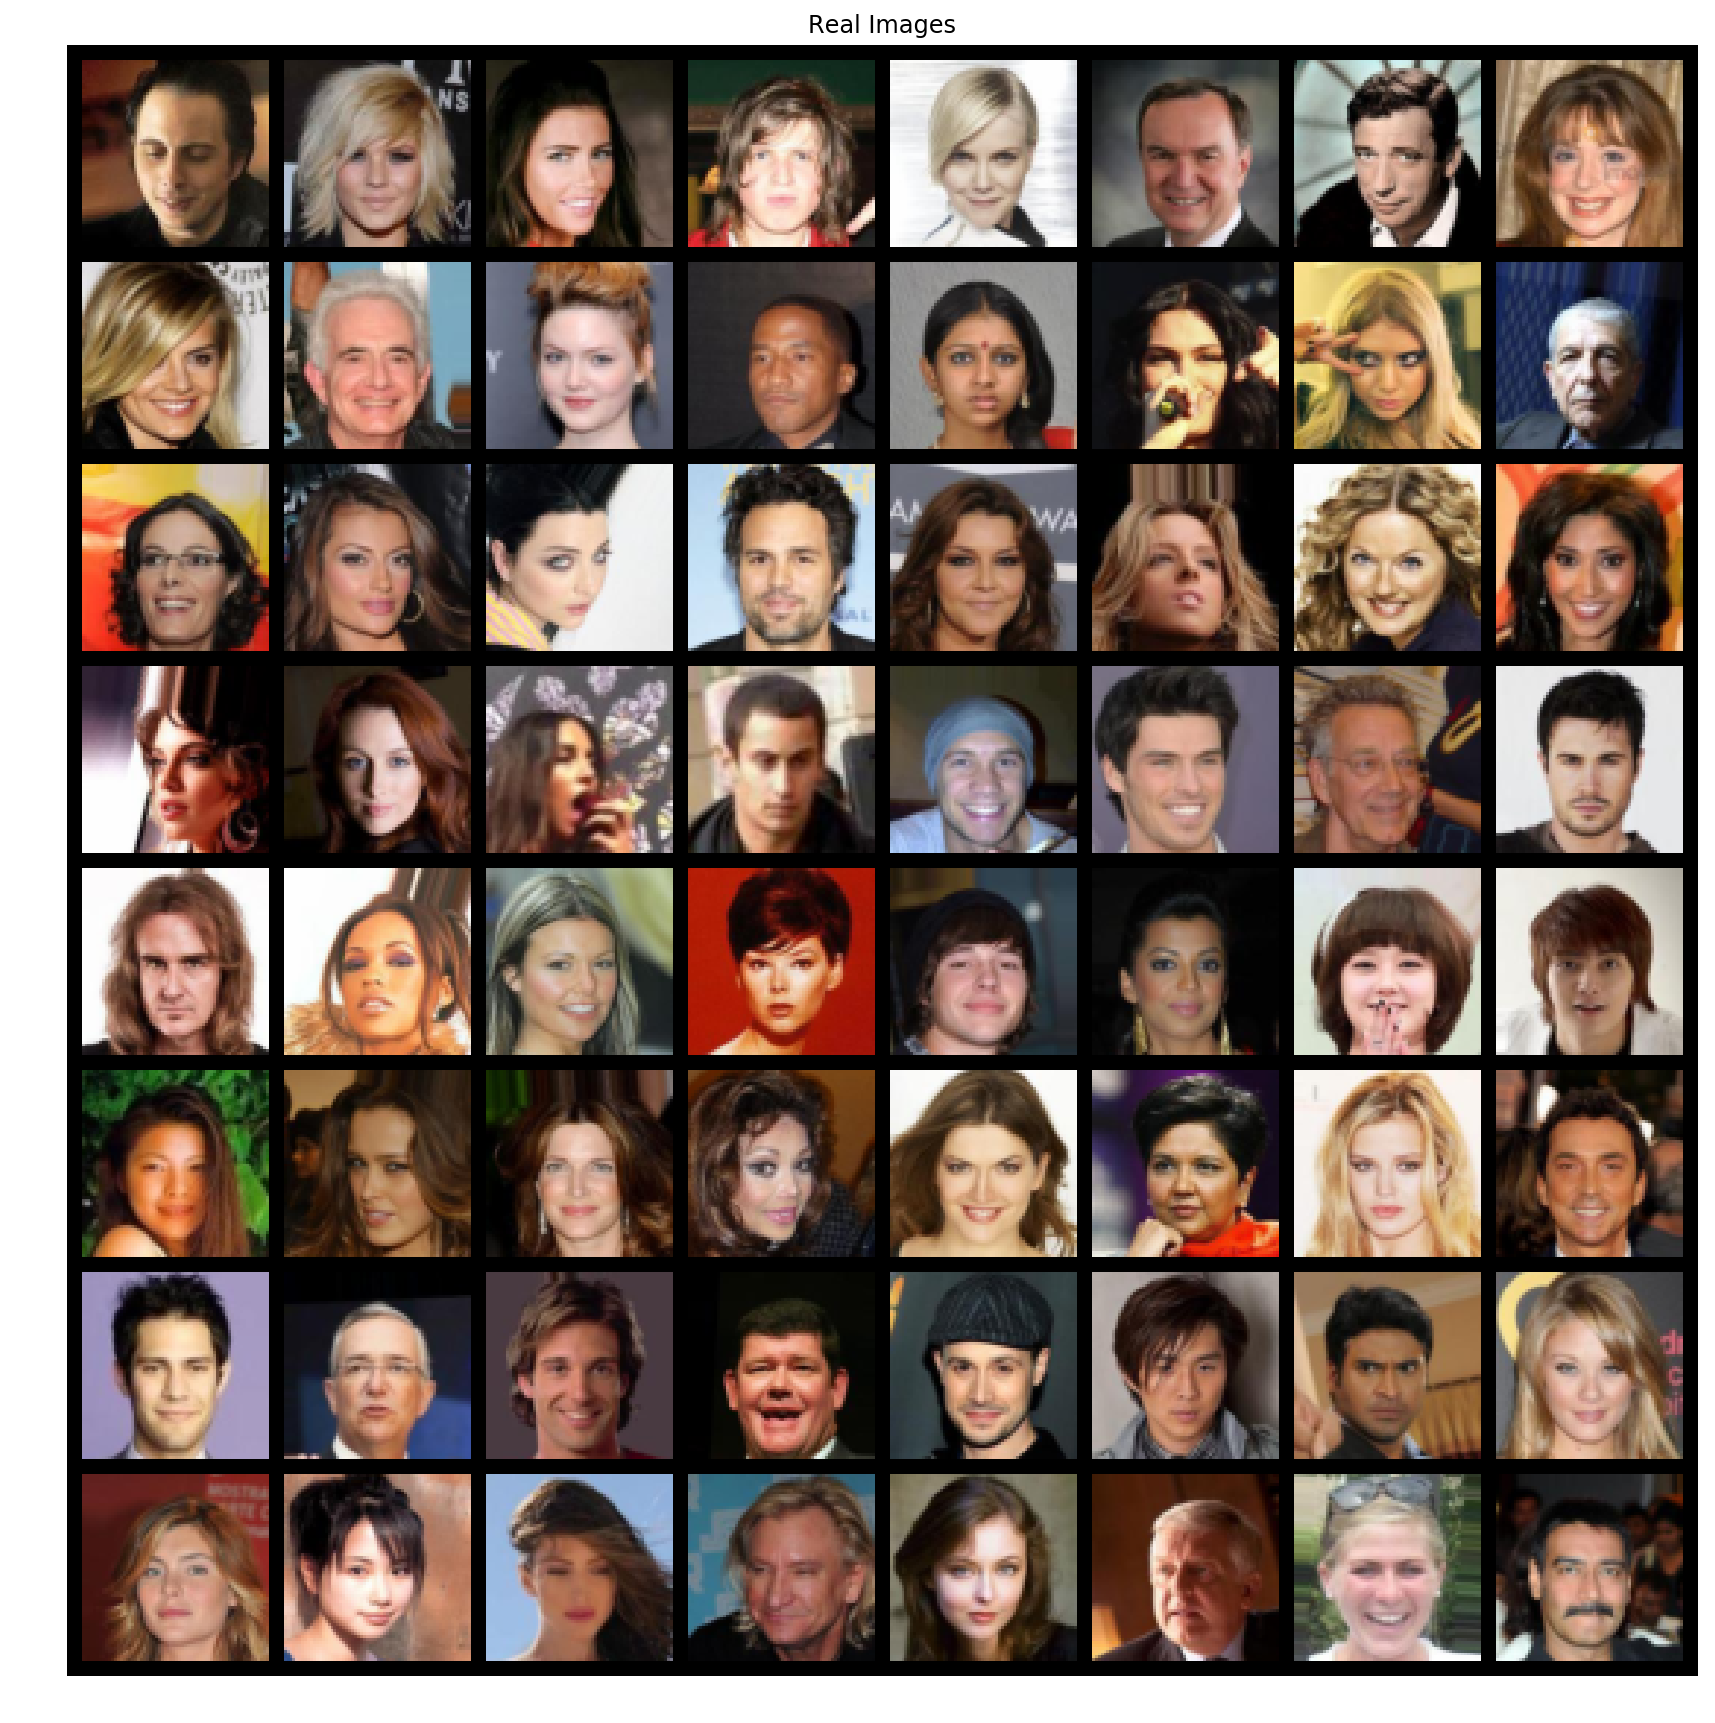

In [3]:
def choose_random_attribute(target):
    """Given multiclass attribute vector, choose one attribute randomly."""
    return random.choice([i for i, x in enumerate(target) if x == 1])

def is_smiling(target):
    return target[31]

# Create the dataset with transforms.
dataset = torchvision.datasets.CelebA(dataroot,
                                      download=download,
                                      transform=transforms.Compose([
                                          transforms.Resize(resolution),
                                          transforms.CenterCrop(resolution),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5),  # Normalize between -1 and 1.
                                                               (0.5, 0.5, 0.5))]),
                                       target_transform=is_smiling)
# Create the dataloader.
dataloader = torch.utils.data.DataLoader(dataset, 
                                         shuffle=True,
                                         batch_size=D_batch_size,
                                         num_workers=num_workers)
# Let's take a look at some samples
vutils.visualize_data(dataloader)

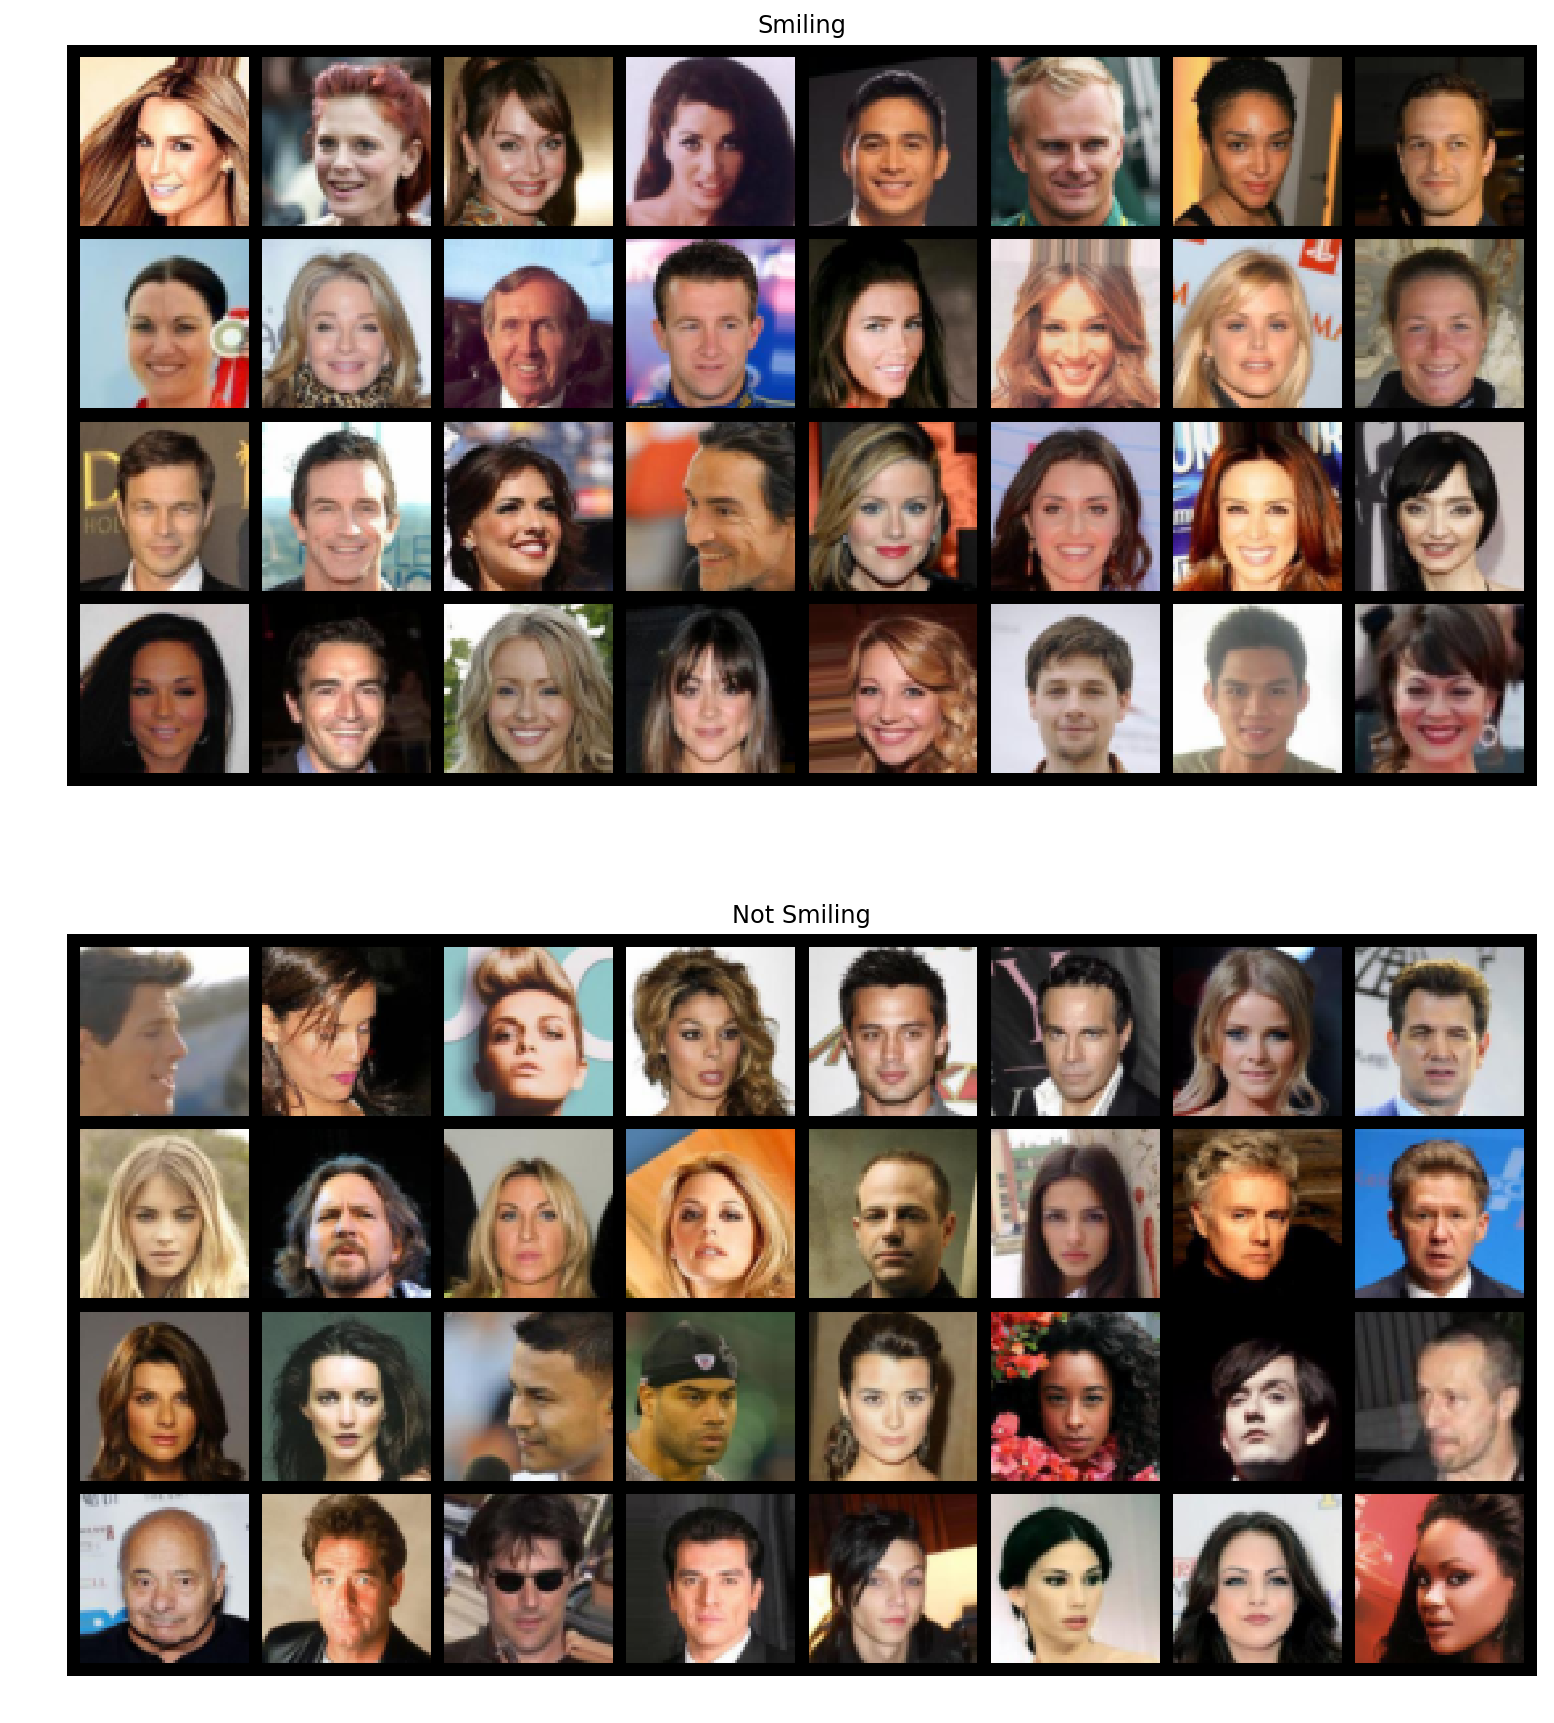

In [4]:
i = 0
num_samples = 32
smiling = []
not_smiling = []
while any([len(x) < num_samples for x in [smiling, not_smiling]]):
    img, is_smiling = dataset[i]
    if is_smiling == 1:
        smiling.append(img)
    else:
        not_smiling.append(img)
    i += 1
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.axis("off")
plt.title("Smiling")
plt.imshow(np.transpose(torchvision.utils.make_grid(smiling[:num_samples],
                                                    padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Not Smiling")
plt.imshow(np.transpose(torchvision.utils.make_grid(not_smiling[:num_samples],
                                                    padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

### Using your own data

If you would like to train a GAN on a your own custom dataset, subclassing [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is a sensible approach as it allows you to make use of PyTorch's dataloading utilities, including the multi-threaded dataLoader and transforms from above.

If your training data consist of image files, the [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class facilitates convenient dataloading. Simply arrange your files in the following way:

    root/dogball/xxx.png
    root/dogball/xxy.png
    root/dogball/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png
    
where each subdirectory of `root` is considered an image category containing examples of that category. Then, you can create your dataset with:

```python
dataroot = '/path/to/data/root'
dataset = torchvision.datasets.ImageFolder(dataroot transforms=...)
```

### Prepare data as single HDF5 file (optional, for additional performance)

If your dataset consists of large, high-resolution images, then repeatedly applying transforms to the raw images (cropping, resizing) results in many wasted CPU cycles. Furthermore, increasing your batchsize puts additional I/O strain on your filesystem. Together, these factors may produce a dataloading bottleneck where your GPUs consume data faster than your system can produce it. To remedy this, you may choose to prepare a pre-processed HDF5 version of your target dataset using the utilities provided.

Another advantage to using a single, preprocessed HDF5 is the ease with which you can transfer data to multiple remote machines, which normally becomes cumbersome and time consuming when attempting large, distributed experiments.

### Prepare to measure sample quality during training (optional, not always possible)

Typically, when training any sort of neural network, it is standard practice to monitor the value of the objective function (loss) throughout the course of the experiment. With GANs, it is also common to break the loss into individual components. However, the adversarial losses measure the competition between the generator and discriminator and do not necessarily reflect the image quality of generated samples. Without an objective measure of image quality, comparing models, monitoring progress and tuning models is near impossible.

In the early day of GAN research, samples were compared visually, which obviously has several issues (ratings could be highly subjective and biases, and evaluating at scale is difficult). On the other hand, objectively evaluating implicit generative models still remains difficult and an active area of investigation. Despite their notable flaws, researchers have recently settled on two popular metrics, which aim to capture image quality and diversity:

- **Inception Score (IS):** Score based on how confidently an ImageNet-pretrained InceptionV3 network can classify generated samples and the diversity of its predictions over large collection of samples. If a model produces samples that InceptionV3 can confidently classify, this contributes to a higher IS. A high diversity of classifications also contributes to a higher IS. 

- **Fréchet Distance (FID):** Measures the distance between two distributions. Here, an Inception Network is used to generate feature representations for both the real images from the dataset of interest and generated samples from the model. These feature distributions are model by multivariate Guassian distributions. The shorter the FréchetDistance between these two distributions, the more closely the fake images resemble the real ones. 

Summary

- Higher IS values mean better image quality and diversity (usually).
- Lower FID values mean better image quality and diversity.

#### Some Caveats
Since the InceptionV3 model is trained to classify ImageNet categories, Inception Score can be a very poor measure of quality on datasets other than ImageNet, although not completely uninformative. While the absolute scale of non-ImageNet based datasets might be lower (and not comparable), relative changes in inception score generally still correlate with image quality. An alternative, although not standardized, practice would be to train an Inception Classifier on the datset of interest, and use that trained network to compute inception scores instead.

In [18]:

inception_moments_file = metrics.calculate_inception_moments(dataloader,dataroot,
                                                             '-'.join([dataset_name, str(resolution)]),
                                                             device=device)

def test(G, batch_size, dim_z, n_classes, num_inception_images=20000, num_splits=10):
    def sample():
        with torch.no_grad():
            z = torch.randn(batch_size, dim_z, device=device)
            y = torch.randint(n_classes, (batch_size,), device=device)
            G_z = G(z)
        return G_z, y
    
    # Load pretrained inception network.
    net = metrics.load_inception_net()
    
    # Load precomputed
    data = np.load(inception_moments_file)
    data_mu, data_sigma = data['mu'], data['sigma']
    
    # Accumulate `num_inception_images` inception features and logits.
    pool, logits, labels = metrics.accumulate_inception_activations(sample, net, num_inception_images)
    
    # Compute inception score mean/std from logits averaged over `num_split` splits.
    IS_mean, IS_std = metrics.calculate_inception_score(logits.cpu().numpy(), num_splits)
    
    # Compute mean and covariance of extracted inception features from generated samples.
    mu, sigma = torch.mean(pool, 0), metrics.torch_cov(pool, rowvar=False)
    FID = metrics.torch_calculate_frechet_distance(mu, sigma,
                                                   torch.tensor(data_mu).float().to(mu.device),
                                                   torch.tensor(data_sigma).float().to(sigma.device))    
    return IS_mean.cpu(), FID.cpu()

100%|██████████| 636/636 [02:16<00:00,  4.84it/s]


Calculating inception metrics...
Training data from has IS of 3.17120 +/- 0.01621
Calculating means and covariances...
Saving calculated means and covariances to disk...
Saved data/CelebA-64_inception_moments.npz


## Convolutional GANS 

[Deep Convolutional GANS](https://arxiv.org/abs/1511.06434) (DCGANs) represented a major step forward in the sucess of GAN image synthesis by modeling $G$ and $D$ with covolutional neural networks. It stands as one of the most popular and successfull baseline GAN architectures.

**Challenge:** Design a neural network architecture for efficient and stable image generation. 

**Solution:** A fully convolutional network that does away with max pooling and fully connected layers. Convolutions had already proven successful for disciminative computer vision tasks since they are well suited for handling the spatial structure of images, and were introduced to GANs in this paper. The design introduces several important architectural elements:

- **Strided (Transposed) Convolutions**: The discriminator uses strided convolutions (instead of maxpooling) for downsampling the spatial dimensions. The generator uses strided transpose convolutions for upsampling.

- **Batch normalization following convolutional layers** works to combat poor initialization schemes and mode collapse. *Recall, batch norm works by normalizing the inputs features to have zero mean and unit variance.*

- **Non-linearity choices:** The generator uses ReLUs except for the output, which uses tanh. The discriminator uses LeakReLUs, which pass along small gradient signals for negative values. As a result, the discriminator can provide the generator with stronger gradients.

Below is a figure depicting the design of the Generator:
![DCGAN Generator Architecure](assets/dcgan_generator.png)

Almost all GANs used for image synthesis build on ideas introduced by DCGAN, although some modern architectures are starting to deviate from these early design decisions. None-the-less, due to its simplicity and success, DCGAN remains a good starting point for a new project.


### Implementation

In this implementation, we will build the DCGAN generator out of `GBlock`s, which increase the spatial dimensions while decreasing the feature volume depth. In this way, we can increase the desired output resolution by simply adding more blocks to our model.

In [6]:
class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size, stride,
                                       padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(True)

    def forward(self, input):
        """Forward method of GBlock.

        By default, this block increases the spatial resolution by 2:

            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, 2*H, 2*W]
        """

        x = self.conv(input)
        x = self.bn(x)
        out = self.act(x)
        return out

    
class Generator(nn.Module):
    """DCGAN Generator."""

    # Maps output resoluton to number of GBlocks.
    res2blocks = {32: 3, 64: 4, 128: 5, 256: 6, 512: 7}

    def __init__(self, dim_z=100, resolution=64, G_ch=64, block=GBlock, init='N02'):
        super().__init__()

        self.G_ch = G_ch
        self.init = init
        self.dim_z = dim_z

        self.num_blocks = self.res2blocks[resolution]
        
        # Determine number of channels at each layer.
        # of the form G_ch * [..., 32, 16, 8, 4, 2, 1]
        self.ch_nums = [G_ch * (2**i) for i in range(self.num_blocks, 0, -1)]
        
        # Input layer: latent z is fed into convolution.
        self.input = block(dim_z, self.ch_nums[0], kernel_size=4, stride=1, padding=0)
        
        # Build our GBlocks 
        self.GBlocks = nn.Sequential(*[
            block(in_c, out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])
        
        # Final output layer produces RGB image with shape [3, resolution, resolution]
        self.out = nn.ConvTranspose2d(self.ch_nums[-1], 3, 4, 2, 1)  # RGB image has 3 channels
        self.tanh = nn.Tanh()                                        # "Squashes" out to be in range[-1, 1]
        
        self.init_weights()
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input(x)
        
        x = self.GBlocks(x)
        x = self.out(x)
        return self.tanh(x)
    
    def init_weights(self):
        for module in self.modules():
            if (isinstance(module, nn.Conv2d)
                or isinstance(module, nn.Linear)
                or isinstance(module, nn.Embedding)):
                if self.init == 'ortho':
                    init.orthogonal_(module.weight)
                elif self.init == 'N02':
                    init.normal_(module.weight, 0, 0.02)
                elif self.init in ['glorot', 'xavier']:
                    init.xavier_uniform_(module.weight)

`DBlocks`, found in the discriminator, are near inverses to `GBlocks`, trading spatial dimension for feature depth, with the exception of using LearkyReLUs instead of ReLUs for their nonlinearities.

In [7]:
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size, stride, padding,
                              bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        """Forward method of DBlock.
        
        This block decreases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, H/2, W/2]
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Discriminator(nn.Module):
    """DCGAN discriminator."""

    # Maps output resoluton to number of DBlocks.
    res2blocks = {32: 3, 64: 4, 128: 5, 256: 6, 512: 7}

    def __init__(self, resolution=128, D_ch=64, block=DBlock):
        super().__init__()

        self.D_ch = D_ch
        # Determine number of channels at each layer.
        # Now, it's of the form D_ch * [1, 2, 4, 8, 16,]
        self.num_blocks = self.res2blocks[resolution]
        self.ch_nums = [2**i for i in range(self.num_blocks)]

        # No batchnorm in the input layer.
        self.input = nn.Sequential(
            nn.Conv2d(3, D_ch, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.DBlocks = nn.Sequential(*[
            block(D_ch * in_c, D_ch * out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])

        # Output is scalar converted to a probability.
        self.out = nn.Conv2d(D_ch * self.ch_nums[-1], 1, 4, 1, 0)
        self.act = nn.Sigmoid() # Sigmoid activation function.

    def forward(self, x):
        x = self.input(x)
        x = self.DBlocks(x)
        x = self.out(x)
        x = self.act(x)
        return x.view(-1)

When building a new GAN, it can really useful to see exactly how the shape of the data changes as it is transformed from noise to RGB image. We provide a small utility for capturing the intermediate sizes and use it below: 

Generator(
  (input): GBlock(
    (conv): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace)
  )
  (GBlocks): Sequential(
    (0): GBlock(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (2): GBlock(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )

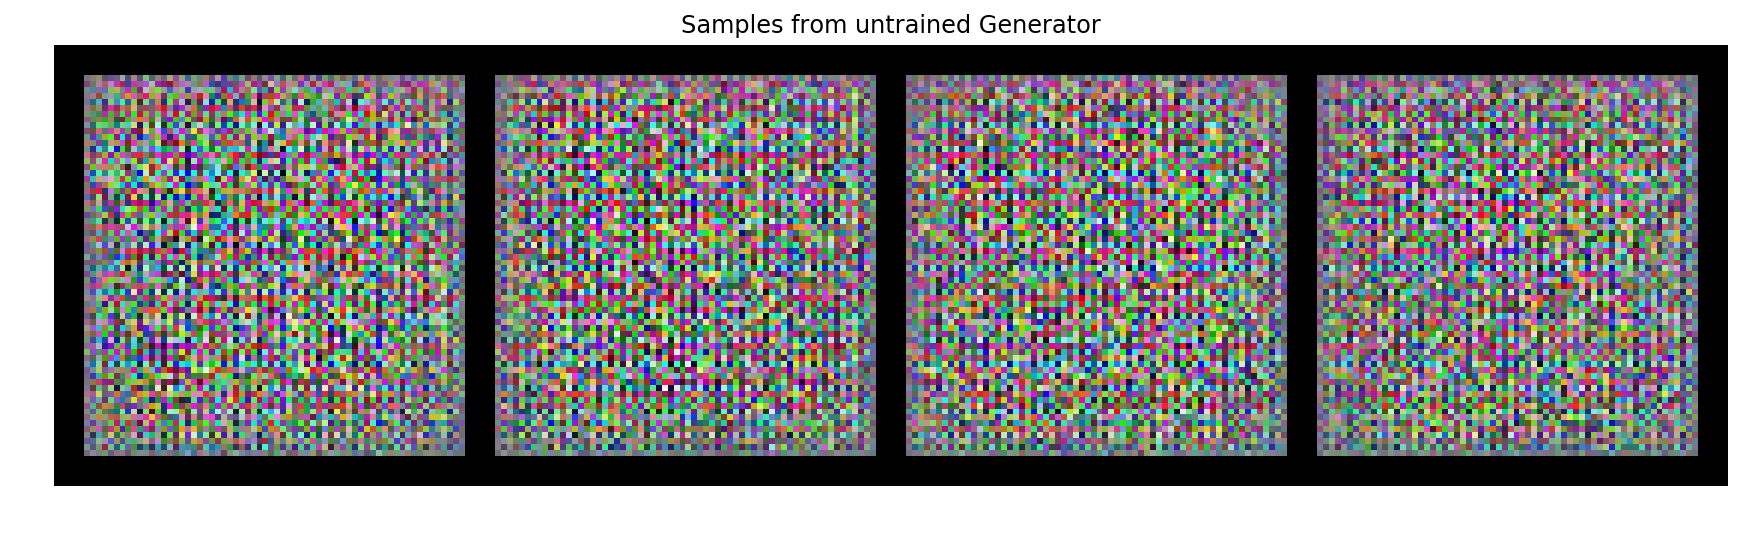

In [8]:
# Instantiate DCGAN Generator instance.
G = Generator(dim_z=dim_z, resolution=resolution).to(device)
print(G)  # View model architecture.

# Create some input tensors.
z = torch.randn(4, G.dim_z, device=device)

# Generate samples while capturing the sizes of intermediate outputs.
Gz, names, sizes = mutils.hook_sizes(G, inputs=(z,), verbose=True)
vutils.visualize_samples(Gz, title='Samples from untrained Generator')

In [9]:
# Create the Discriminator
D = models.dcgan.Discriminator(resolution=resolution).to(device)
print(D)  # View discriminator architecture.

# Let's pass the output of the generator to the dicriminator.
D_Gz, names, sizes = mutils.hook_sizes(D, inputs=(Gz,), verbose=True)
print('D(G(z)) should be probabilities: {}'.format(D_Gz))

Discriminator(
  (input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (DBlocks): Sequential(
    (0): DBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): DBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): DBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (out): C

## Loss Functions and Optimizers
Despite a growing body of research  focused on modifying the objective function to encourage convergence, we will retain the original "Non Saturating" variant of the GAN loss function, which is commonly applied via PyTorch's [`BCELoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)
function which is defined as

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

The key observations are that:

- when $y_n = 1$, $l_n = -\log x_n$
- when $y_n = 0$, $l_n = -\log(1 - x_n)$

In [10]:
# Handle multi-gpu if desired.
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
    D = nn.DataParallel(D, list(range(ngpu)))
    
# Initialize BCELoss function.
criterion = nn.BCELoss()
# Note: criterion(x, 1) = -log(x)
#       criterion(x, 0) = -log(1 - x)

# Create batch of latent vectors that we will use to visualize
# the progression of the generator.
fixed_noise = torch.randn(batch_size, dim_z, device=device)
fixed_labels = torch.randint(n_classes, (batch_size, ), device=device)


# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
G_optim = optim.Adam(G.parameters(), lr=G_lr, betas=G_betas)
D_optim = optim.Adam(D.parameters(), lr=D_lr, betas=D_betas)

In [11]:
img_list = []
G_losses = []
D_losses = []
IS_scores = []
FIDs = []
iters = 0
best_IS = 0
best_FID = 9999

In [12]:
# Training Loop
if TRAIN:
    print("Starting Training Loop...")
    
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            
            counter = 0 # Keep track of "mini-batches"
            data = [d.to(device) for d in data]
            x, y = [torch.split(d, batch_size) for d in data]
            
            real_labels = torch.full((batch_size,), real_label, device=device)
            fake_labels = torch.full((batch_size,), fake_label, device=device) 
            
            #################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            #################################################################

            D.zero_grad()            
            for step_index in range(num_D_steps):
                D.zero_grad()
                for accumulation_index in range(num_D_accumulations):
                    
                    ## ** Train with all-real batch ** ##

                    # Forward real batch through D
                    output = D(x[counter]).view(-1)
                    
                    # Calculate loss on all-real batch
                    D_loss_real = criterion(output, real_labels[:output.size(0)]) / float(num_D_accumulations)
                    D_loss_real.backward()
                    D_x = output.mean().item()

                    ## ** Train with all-fake batch ** ##
                
                    # Generate batch of latent vectors and targets
                    noise = torch.randn(batch_size, dim_z, device=device)
                    
                    # Generate fake image batch with G
                    fake_image = G(noise)

                    # Classify all fake batch with D
                    output = D(fake_image.detach()).view(-1)

                    # Calculate D's loss on the all-fake batch
                    D_loss_fake = criterion(output, fake_labels[:output.size(0)]) / float(num_D_accumulations)
                    D_loss_fake.backward()
                    D_G_z1 = output.mean().item()
                    
                    # Add the gradients from the all-real and all-fake batches
                    D_loss = (D_loss_real + D_loss_fake)
                    counter += 1
                    
                # Update D
                D_optim.step()

            #############################################
            # (2) Update G network: maximize log(D(G(z)))
            #############################################
            
            G.zero_grad()
            for accumulation_index in range(num_G_accumulations):
                
                # Generate batch of latent vectors and targets
                noise = torch.randn(batch_size, dim_z, device=device)
                targets = torch.randint(n_classes, (batch_size,), device=device)
                
                fake_image = G(noise)
                output = D(fake_image).view(-1)
                
                # Calculate G's loss based on this output
                G_loss = criterion(output, real_labels) / float(num_G_accumulations)
                    
                # Calculate gradients for G
                G_loss.backward()
                D_G_z2 = output.mean().item()
                
            # Update G
            G_optim.step()
            
            # Output training stats
            if i % 10 == 0:
                print('[{}/{}][{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f} / {:.4f}'.
                     format(epoch, num_epochs, i, len(dataloader),
                            D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())

            # Check how the generator is doing by saving G's samples on fixed_noise
            if (iters % sample_every == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake_image = G(fixed_noise).detach().cpu()
                    
                # Save to disk and keep copy in list
                fname = os.path.join(samples_dir, model_name, f'{iters:06d}.jpg')
                torchvision.utils.save_image(fake_image, fname, padding=2, normalize=True )
                img_list.append(torchvision.utils.make_grid(fake_image, padding=2, normalize=True))
                
            if ((iters % test_every == 0 and test_every != 0)
                or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1))):
                
                with torch.no_grad():
                    IS, FID = test(G, batch_size, dim_z, n_classes)
                print('Itr {}: PYTORCH Inception Score is {:3.3f} '
                      'PYTORCH FID is {:5.4f}'.format(iters, IS, FID))
                IS_scores.append(IS)
                FIDs.append(FID)
                # Remember best IS and FID and save checkpoint.
                is_best_IS = IS > best_IS
                is_best_FID = FID < best_FID
                best_IS = max(IS, best_IS)
                best_FID = min(FID, best_FID)

                mutils.save_checkpoint({
                    'G': G.state_dict(),
                    'D': D.state_dict(),
                    'iters': iters,
                    'epoch': epoch,
                    'IS_scores': IS_scores,
                    'FIDs': FIDs,
                    'best_IS': best_IS,
                    'best_FID': best_FID,
                }, is_best_IS, is_best_FID, 
                    filename=save_name + '.pth.tar')
                    
            iters += 1
        # Finally, save a checkpoint every epoch.
        torch.save({
            'G': G.state_dict(),
            'D': D.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
            'iters': iters,
            'epoch': epoch,
            'IS_scores': IS_scores,
            'FIDs': FIDs,
            'best_IS': best_IS,
            'best_FID': best_FID,
            }, f'{save_name}_epoch{epoch}.pth.tar')

Starting Training Loop...
[0/200][0/636]	Loss_D: 1.4926	Loss_G: 1.2787	D(x): 0.4809	D(G(z)): 0.5272 / 0.2813
Itr 0: PYTORCH Inception Score is 1.200 PYTORCH FID is 382.9256
[0/200][10/636]	Loss_D: 0.6903	Loss_G: 3.9593	D(x): 0.7863	D(G(z)): 0.3365 / 0.0197
[0/200][20/636]	Loss_D: 0.5778	Loss_G: 5.1646	D(x): 0.7956	D(G(z)): 0.2517 / 0.0061
[0/200][30/636]	Loss_D: 0.3008	Loss_G: 5.3391	D(x): 0.8285	D(G(z)): 0.0685 / 0.0053
[0/200][40/636]	Loss_D: 0.2379	Loss_G: 5.8212	D(x): 0.8653	D(G(z)): 0.0637 / 0.0037
[0/200][50/636]	Loss_D: 0.2192	Loss_G: 4.5716	D(x): 0.8927	D(G(z)): 0.0879 / 0.0135
[0/200][60/636]	Loss_D: 0.5131	Loss_G: 5.7944	D(x): 0.8794	D(G(z)): 0.2934 / 0.0043
[0/200][70/636]	Loss_D: 1.2056	Loss_G: 3.0178	D(x): 0.8616	D(G(z)): 0.5986 / 0.0635
[0/200][80/636]	Loss_D: 1.1121	Loss_G: 2.5029	D(x): 0.6453	D(G(z)): 0.4530 / 0.0874
[0/200][90/636]	Loss_D: 1.2098	Loss_G: 1.8830	D(x): 0.6028	D(G(z)): 0.4738 / 0.1659
[0/200][100/636]	Loss_D: 1.2096	Loss_G: 1.9627	D(x): 0.5722	D(G(z)): 0.

[1/200][260/636]	Loss_D: 0.9604	Loss_G: 1.8713	D(x): 0.5264	D(G(z)): 0.2118 / 0.1787
Itr 900: PYTORCH Inception Score is 2.468 PYTORCH FID is 197.4177
[1/200][270/636]	Loss_D: 1.2664	Loss_G: 2.7532	D(x): 0.7817	D(G(z)): 0.6073 / 0.0737
[1/200][280/636]	Loss_D: 0.9495	Loss_G: 2.1828	D(x): 0.6330	D(G(z)): 0.3477 / 0.1291
[1/200][290/636]	Loss_D: 1.2293	Loss_G: 1.2943	D(x): 0.4021	D(G(z)): 0.1876 / 0.3043
[1/200][300/636]	Loss_D: 0.9695	Loss_G: 2.1424	D(x): 0.6513	D(G(z)): 0.3760 / 0.1343
[1/200][310/636]	Loss_D: 0.8975	Loss_G: 1.9761	D(x): 0.7141	D(G(z)): 0.3950 / 0.1623
[1/200][320/636]	Loss_D: 0.9381	Loss_G: 1.7493	D(x): 0.5222	D(G(z)): 0.1730 / 0.2015
[1/200][330/636]	Loss_D: 0.9093	Loss_G: 2.6695	D(x): 0.7753	D(G(z)): 0.4516 / 0.0867
[1/200][340/636]	Loss_D: 1.0232	Loss_G: 2.9516	D(x): 0.8115	D(G(z)): 0.5280 / 0.0617
[1/200][350/636]	Loss_D: 0.9193	Loss_G: 1.6198	D(x): 0.5665	D(G(z)): 0.2510 / 0.2232
[1/200][360/636]	Loss_D: 1.0509	Loss_G: 1.4018	D(x): 0.6261	D(G(z)): 0.3934 / 0.2702

[2/200][520/636]	Loss_D: 0.8264	Loss_G: 1.4400	D(x): 0.6045	D(G(z)): 0.2489 / 0.2584
Itr 1800: PYTORCH Inception Score is 2.154 PYTORCH FID is   nan
[2/200][530/636]	Loss_D: 0.7682	Loss_G: 2.6620	D(x): 0.8102	D(G(z)): 0.4034 / 0.0838
[2/200][540/636]	Loss_D: 0.6304	Loss_G: 2.0772	D(x): 0.7380	D(G(z)): 0.2576 / 0.1431
[2/200][550/636]	Loss_D: 1.1080	Loss_G: 1.5653	D(x): 0.4357	D(G(z)): 0.1724 / 0.2393
[2/200][560/636]	Loss_D: 1.0794	Loss_G: 2.1991	D(x): 0.5911	D(G(z)): 0.3786 / 0.1306
[2/200][570/636]	Loss_D: 1.0007	Loss_G: 2.0104	D(x): 0.6410	D(G(z)): 0.3871 / 0.1542
[2/200][580/636]	Loss_D: 1.1479	Loss_G: 1.1460	D(x): 0.4165	D(G(z)): 0.1622 / 0.3449
[2/200][590/636]	Loss_D: 1.0800	Loss_G: 2.6095	D(x): 0.7691	D(G(z)): 0.5304 / 0.0915
[2/200][600/636]	Loss_D: 0.8868	Loss_G: 1.6299	D(x): 0.5648	D(G(z)): 0.2258 / 0.2191
[2/200][610/636]	Loss_D: 2.3801	Loss_G: 1.0449	D(x): 0.1147	D(G(z)): 0.0346 / 0.3800
[2/200][620/636]	Loss_D: 0.7785	Loss_G: 2.1003	D(x): 0.6797	D(G(z)): 0.2965 / 0.1454
I

[4/200][140/636]	Loss_D: 0.9436	Loss_G: 2.4641	D(x): 0.7789	D(G(z)): 0.4787 / 0.1005
[4/200][150/636]	Loss_D: 1.1296	Loss_G: 1.1465	D(x): 0.3925	D(G(z)): 0.1119 / 0.3428
Itr 2700: PYTORCH Inception Score is 2.158 PYTORCH FID is   nan
[4/200][160/636]	Loss_D: 1.2591	Loss_G: 4.0007	D(x): 0.8677	D(G(z)): 0.6513 / 0.0231
[4/200][170/636]	Loss_D: 0.9015	Loss_G: 1.9185	D(x): 0.6648	D(G(z)): 0.3644 / 0.1640
[4/200][180/636]	Loss_D: 0.8041	Loss_G: 1.3008	D(x): 0.6557	D(G(z)): 0.2965 / 0.2978
[4/200][190/636]	Loss_D: 1.1191	Loss_G: 2.7582	D(x): 0.8650	D(G(z)): 0.6036 / 0.0753
[4/200][200/636]	Loss_D: 0.8806	Loss_G: 1.7003	D(x): 0.6501	D(G(z)): 0.3347 / 0.2006
[4/200][210/636]	Loss_D: 1.0531	Loss_G: 1.0301	D(x): 0.4257	D(G(z)): 0.1303 / 0.3786
[4/200][220/636]	Loss_D: 0.9553	Loss_G: 2.3920	D(x): 0.8463	D(G(z)): 0.5263 / 0.1069
[4/200][230/636]	Loss_D: 0.9215	Loss_G: 1.6417	D(x): 0.7222	D(G(z)): 0.4232 / 0.2176
[4/200][240/636]	Loss_D: 1.0163	Loss_G: 1.0676	D(x): 0.4564	D(G(z)): 0.1602 / 0.3624
[

[5/200][400/636]	Loss_D: 1.0093	Loss_G: 1.0319	D(x): 0.4980	D(G(z)): 0.2333 / 0.3737
[5/200][410/636]	Loss_D: 1.0440	Loss_G: 1.5465	D(x): 0.6509	D(G(z)): 0.4340 / 0.2340
[5/200][420/636]	Loss_D: 0.9546	Loss_G: 1.6728	D(x): 0.6089	D(G(z)): 0.3390 / 0.2067
Itr 3600: PYTORCH Inception Score is 2.197 PYTORCH FID is   nan
[5/200][430/636]	Loss_D: 1.2324	Loss_G: 2.4398	D(x): 0.8526	D(G(z)): 0.6377 / 0.0991
[5/200][440/636]	Loss_D: 1.2135	Loss_G: 0.8943	D(x): 0.4264	D(G(z)): 0.2469 / 0.4319
[5/200][450/636]	Loss_D: 0.9152	Loss_G: 1.6946	D(x): 0.6810	D(G(z)): 0.3893 / 0.2003
[5/200][460/636]	Loss_D: 0.9382	Loss_G: 1.4721	D(x): 0.6461	D(G(z)): 0.3677 / 0.2524
[5/200][470/636]	Loss_D: 1.0935	Loss_G: 1.6243	D(x): 0.6983	D(G(z)): 0.4963 / 0.2137
[5/200][480/636]	Loss_D: 1.1863	Loss_G: 0.7950	D(x): 0.3991	D(G(z)): 0.1793 / 0.4672
[5/200][490/636]	Loss_D: 1.0191	Loss_G: 1.8233	D(x): 0.8011	D(G(z)): 0.5250 / 0.1793
[5/200][500/636]	Loss_D: 0.9613	Loss_G: 1.6121	D(x): 0.6319	D(G(z)): 0.3673 / 0.2175
[

[7/200][20/636]	Loss_D: 1.0005	Loss_G: 1.5957	D(x): 0.6275	D(G(z)): 0.3852 / 0.2211
[7/200][30/636]	Loss_D: 1.3057	Loss_G: 0.9619	D(x): 0.3727	D(G(z)): 0.1919 / 0.4066
[7/200][40/636]	Loss_D: 1.0566	Loss_G: 1.4137	D(x): 0.5566	D(G(z)): 0.3363 / 0.2654
Itr 4500: PYTORCH Inception Score is 2.205 PYTORCH FID is   nan
[7/200][50/636]	Loss_D: 0.8899	Loss_G: 1.2833	D(x): 0.6197	D(G(z)): 0.3088 / 0.2996
[7/200][60/636]	Loss_D: 1.1076	Loss_G: 1.2128	D(x): 0.4663	D(G(z)): 0.2490 / 0.3224
[7/200][70/636]	Loss_D: 1.0923	Loss_G: 2.5176	D(x): 0.8095	D(G(z)): 0.5604 / 0.0940
[7/200][80/636]	Loss_D: 0.9660	Loss_G: 1.6253	D(x): 0.6838	D(G(z)): 0.4183 / 0.2159
[7/200][90/636]	Loss_D: 1.1551	Loss_G: 1.0621	D(x): 0.3921	D(G(z)): 0.1431 / 0.3705
[7/200][100/636]	Loss_D: 1.0147	Loss_G: 1.6692	D(x): 0.7165	D(G(z)): 0.4687 / 0.2117
[7/200][110/636]	Loss_D: 1.0965	Loss_G: 1.8282	D(x): 0.6778	D(G(z)): 0.4838 / 0.1837
[7/200][120/636]	Loss_D: 0.9848	Loss_G: 1.0801	D(x): 0.4814	D(G(z)): 0.1838 / 0.3627
[7/200][1

[8/200][280/636]	Loss_D: 1.0231	Loss_G: 1.1308	D(x): 0.5520	D(G(z)): 0.3121 / 0.3514
[8/200][290/636]	Loss_D: 1.1184	Loss_G: 1.8825	D(x): 0.7221	D(G(z)): 0.5130 / 0.1757
[8/200][300/636]	Loss_D: 1.0790	Loss_G: 1.9419	D(x): 0.7279	D(G(z)): 0.4996 / 0.1676
[8/200][310/636]	Loss_D: 1.4978	Loss_G: 0.6427	D(x): 0.2789	D(G(z)): 0.1186 / 0.5480
Itr 5400: PYTORCH Inception Score is 2.378 PYTORCH FID is   nan
[8/200][320/636]	Loss_D: 0.9838	Loss_G: 1.7633	D(x): 0.7464	D(G(z)): 0.4713 / 0.1912
[8/200][330/636]	Loss_D: 0.9516	Loss_G: 1.9370	D(x): 0.6988	D(G(z)): 0.4213 / 0.1626
[8/200][340/636]	Loss_D: 1.2290	Loss_G: 2.2423	D(x): 0.8115	D(G(z)): 0.6134 / 0.1241
[8/200][350/636]	Loss_D: 1.1160	Loss_G: 0.8756	D(x): 0.4412	D(G(z)): 0.2059 / 0.4391
[8/200][360/636]	Loss_D: 0.9092	Loss_G: 1.2826	D(x): 0.5653	D(G(z)): 0.2587 / 0.3021
[8/200][370/636]	Loss_D: 1.0286	Loss_G: 1.8131	D(x): 0.6908	D(G(z)): 0.4541 / 0.1819
[8/200][380/636]	Loss_D: 1.2499	Loss_G: 2.8710	D(x): 0.8615	D(G(z)): 0.6439 / 0.0670
[

[9/200][540/636]	Loss_D: 1.0294	Loss_G: 1.1599	D(x): 0.4590	D(G(z)): 0.1717 / 0.3365
[9/200][550/636]	Loss_D: 1.0136	Loss_G: 1.8558	D(x): 0.8044	D(G(z)): 0.5135 / 0.1762
[9/200][560/636]	Loss_D: 0.9262	Loss_G: 1.8414	D(x): 0.7252	D(G(z)): 0.4289 / 0.1819
[9/200][570/636]	Loss_D: 0.9110	Loss_G: 1.6323	D(x): 0.6587	D(G(z)): 0.3597 / 0.2156
Itr 6300: PYTORCH Inception Score is 2.366 PYTORCH FID is   nan
[9/200][580/636]	Loss_D: 1.0509	Loss_G: 2.2935	D(x): 0.8145	D(G(z)): 0.5440 / 0.1200
[9/200][590/636]	Loss_D: 1.3679	Loss_G: 2.3496	D(x): 0.8660	D(G(z)): 0.6736 / 0.1147
[9/200][600/636]	Loss_D: 1.0216	Loss_G: 1.6822	D(x): 0.6758	D(G(z)): 0.4364 / 0.2115
[9/200][610/636]	Loss_D: 0.9851	Loss_G: 1.9521	D(x): 0.6957	D(G(z)): 0.4267 / 0.1690
[9/200][620/636]	Loss_D: 0.8226	Loss_G: 1.4669	D(x): 0.6422	D(G(z)): 0.2839 / 0.2603
[9/200][630/636]	Loss_D: 1.2998	Loss_G: 0.6201	D(x): 0.3559	D(G(z)): 0.1658 / 0.5594
[10/200][0/636]	Loss_D: 2.1882	Loss_G: 0.4865	D(x): 0.1668	D(G(z)): 0.0548 / 0.6463
[1

[11/200][150/636]	Loss_D: 0.8899	Loss_G: 1.5279	D(x): 0.6208	D(G(z)): 0.3028 / 0.2415
[11/200][160/636]	Loss_D: 0.8015	Loss_G: 1.4403	D(x): 0.5770	D(G(z)): 0.1833 / 0.2634
[11/200][170/636]	Loss_D: 0.7638	Loss_G: 1.6826	D(x): 0.6953	D(G(z)): 0.3050 / 0.2056
[11/200][180/636]	Loss_D: 0.9013	Loss_G: 1.0102	D(x): 0.4893	D(G(z)): 0.1167 / 0.3969
[11/200][190/636]	Loss_D: 0.8435	Loss_G: 1.5763	D(x): 0.6410	D(G(z)): 0.2979 / 0.2301
[11/200][200/636]	Loss_D: 0.9188	Loss_G: 1.1712	D(x): 0.5097	D(G(z)): 0.1755 / 0.3341
Itr 7200: PYTORCH Inception Score is 2.488 PYTORCH FID is   nan
[11/200][210/636]	Loss_D: 1.1805	Loss_G: 3.1671	D(x): 0.8879	D(G(z)): 0.6229 / 0.0532
[11/200][220/636]	Loss_D: 1.0878	Loss_G: 0.8365	D(x): 0.4299	D(G(z)): 0.1474 / 0.4554
[11/200][230/636]	Loss_D: 1.1776	Loss_G: 3.0798	D(x): 0.8253	D(G(z)): 0.5981 / 0.0561
[11/200][240/636]	Loss_D: 1.0293	Loss_G: 1.0350	D(x): 0.4915	D(G(z)): 0.2191 / 0.3823
[11/200][250/636]	Loss_D: 0.8429	Loss_G: 1.6503	D(x): 0.6459	D(G(z)): 0.2997

[12/200][400/636]	Loss_D: 0.7423	Loss_G: 1.6473	D(x): 0.6026	D(G(z)): 0.1789 / 0.2229
[12/200][410/636]	Loss_D: 0.7757	Loss_G: 1.8977	D(x): 0.7248	D(G(z)): 0.3398 / 0.1742
[12/200][420/636]	Loss_D: 0.7694	Loss_G: 1.3482	D(x): 0.7092	D(G(z)): 0.3148 / 0.2880
[12/200][430/636]	Loss_D: 0.7351	Loss_G: 1.7760	D(x): 0.7249	D(G(z)): 0.3134 / 0.1890
[12/200][440/636]	Loss_D: 0.9408	Loss_G: 0.9053	D(x): 0.4622	D(G(z)): 0.1169 / 0.4312
[12/200][450/636]	Loss_D: 0.8573	Loss_G: 1.1369	D(x): 0.5376	D(G(z)): 0.1735 / 0.3524
[12/200][460/636]	Loss_D: 0.8549	Loss_G: 1.2919	D(x): 0.6139	D(G(z)): 0.2751 / 0.3036
Itr 8100: PYTORCH Inception Score is 2.499 PYTORCH FID is   nan
[12/200][470/636]	Loss_D: 0.9060	Loss_G: 1.5941	D(x): 0.7884	D(G(z)): 0.4606 / 0.2287
[12/200][480/636]	Loss_D: 0.7163	Loss_G: 1.5731	D(x): 0.6552	D(G(z)): 0.2259 / 0.2339
[12/200][490/636]	Loss_D: 0.8185	Loss_G: 2.2233	D(x): 0.8518	D(G(z)): 0.4528 / 0.1319
[12/200][500/636]	Loss_D: 0.9061	Loss_G: 1.0610	D(x): 0.4864	D(G(z)): 0.1062

KeyboardInterrupt: 

### And we're off!

... And now we wait. At lower resolutions or fewer classes, it is possible to obtain farily respectable results in a short time frames. However, acheiving  the eye-catching results commonly advertised in paper and the media still takes quite a while, on the order of weeks potentially. 

**Note on hardware utilization**: Just got your hands on some shiny new GPUs? Make sure you are using them to the fullest! The command `watch -n 1 nvidia-smi` will show utilization and memory consumption continuously (refresehed every second). Could you use a larger batch size? If you see your GPU usage cycle between 100% and 0% adn Evidence of a dataloading bottleneck?

### "Babysitting" the learning process

Given that training these models can be an investment in time and resources, it's wise to continuously monitor training in order to catch and address anamolies if/when they occur. Here are some things to look out for:

#### What should my loss look like?

GAN losses come in all shapes and sizes and depend on numerous factors including architecture, dataset, and loss function. The adversarial learning process is highly dynamic and high frequency oscillations are quite common:

![Loss Montage](assets/loss_montage.jpg)

**Recommendation:** Make sure losses fall within a reasonable range and *catch failures early!*. If either loss (D or G) skyrockets to huge values, plunge to 0 or get stuck on a single value, there is likely an issue somewhere.If you are training a common architecture, consult the literature/other implementations to ground your expectations. One of the hardest things about re-implementing a paper can be checking if the logs line up early in training, especially if training takes multiple weeks.

**During training**
- Are losses still within normal limits? High frequency oscillations are expected.
- Monitor IS and FID metrics (if applicable) - are they following the expected trajectories? 
- How do the samples look? Are they improving over time? Do you see evidence of mode collapse?

*Mode Collapse*: When the generator produces an extremely limited set output patterns ("modes") despite maintaining diversity of input noise. Here are samples generated by a model undergoing mode collapse:

![Mode Collapse](assets/collapse.jpg)

**End of training**
- Most importantly, do the samples meet your expectations?
- Sharp increase in metrics followed by collapse?
- No longer improving.
- Explore your model!

## Results

Now that we have finished training, let's find out how we did. We will analyze our model in several ways:
1. Examine how D and G’s losses changed during training.
2. Visualize G’s output on the fixed_noise batch for every epoch and create a video.
3. Explore what the Generator has learned in its latent space.

In [13]:
if not TRAIN:
    state_dict = torch.load(save_name)
    G.load_state_dict(state_dict['G'])
    D.load_state_dict(state_dict['D'])
    G_losses, D_losses = state_dict['G_losses'], state_dict['D_losses']

In [38]:
def plot_loss_logs(G_loss, D_loss, smoothing=0.001):
    G_loss = vutils.smooth_data(G_loss, amount=smoothing)
    D_loss = vutils.smooth_data(D_loss, amount=smoothing)
    plt.figure(figsize=(15, 5))
    plt.plot(G_loss, label='G_loss')
    plt.plot(D_loss, label='D_loss')
    plt.legend(loc='lower right', fontsize='medium')
    plt.xlabel('Iteration', fontsize='x-large')
    plt.ylabel('Losses', fontsize='x-large')
    plt.title('Training History', fontsize='xx-large')
    plt.show()
    
    
def plot_metrics(IS_scores, FIDs):
    fig, axs = plt.subplots(2, sharex=True, figsize=(15, 5))
    itrs = np.arange(0, len(IS_scores)) * test_every
    axs[0].plot(itrs, IS_scores)
    axs[1].plot(itrs, FIDs)
    
    for label, ax in zip(['Inception Score', 'FID'], axs.flat):
        ax.set(ylabel=label)
    
    plt.xlabel('Iteration', fontsize='x-large')
    axs[0].set_title('Training History', fontsize='xx-large')
    fig.tight_layout()
    plt.show()

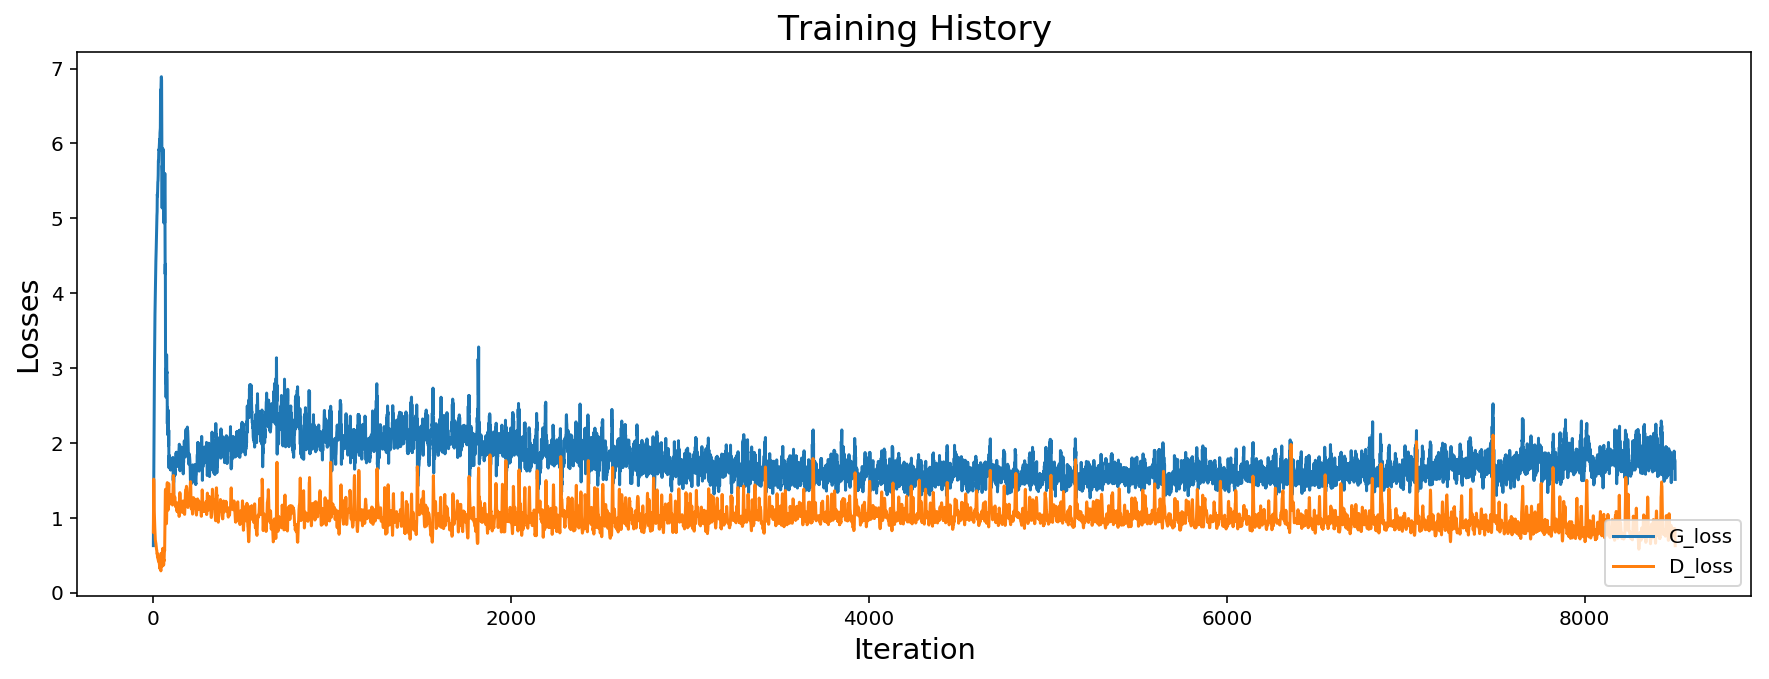

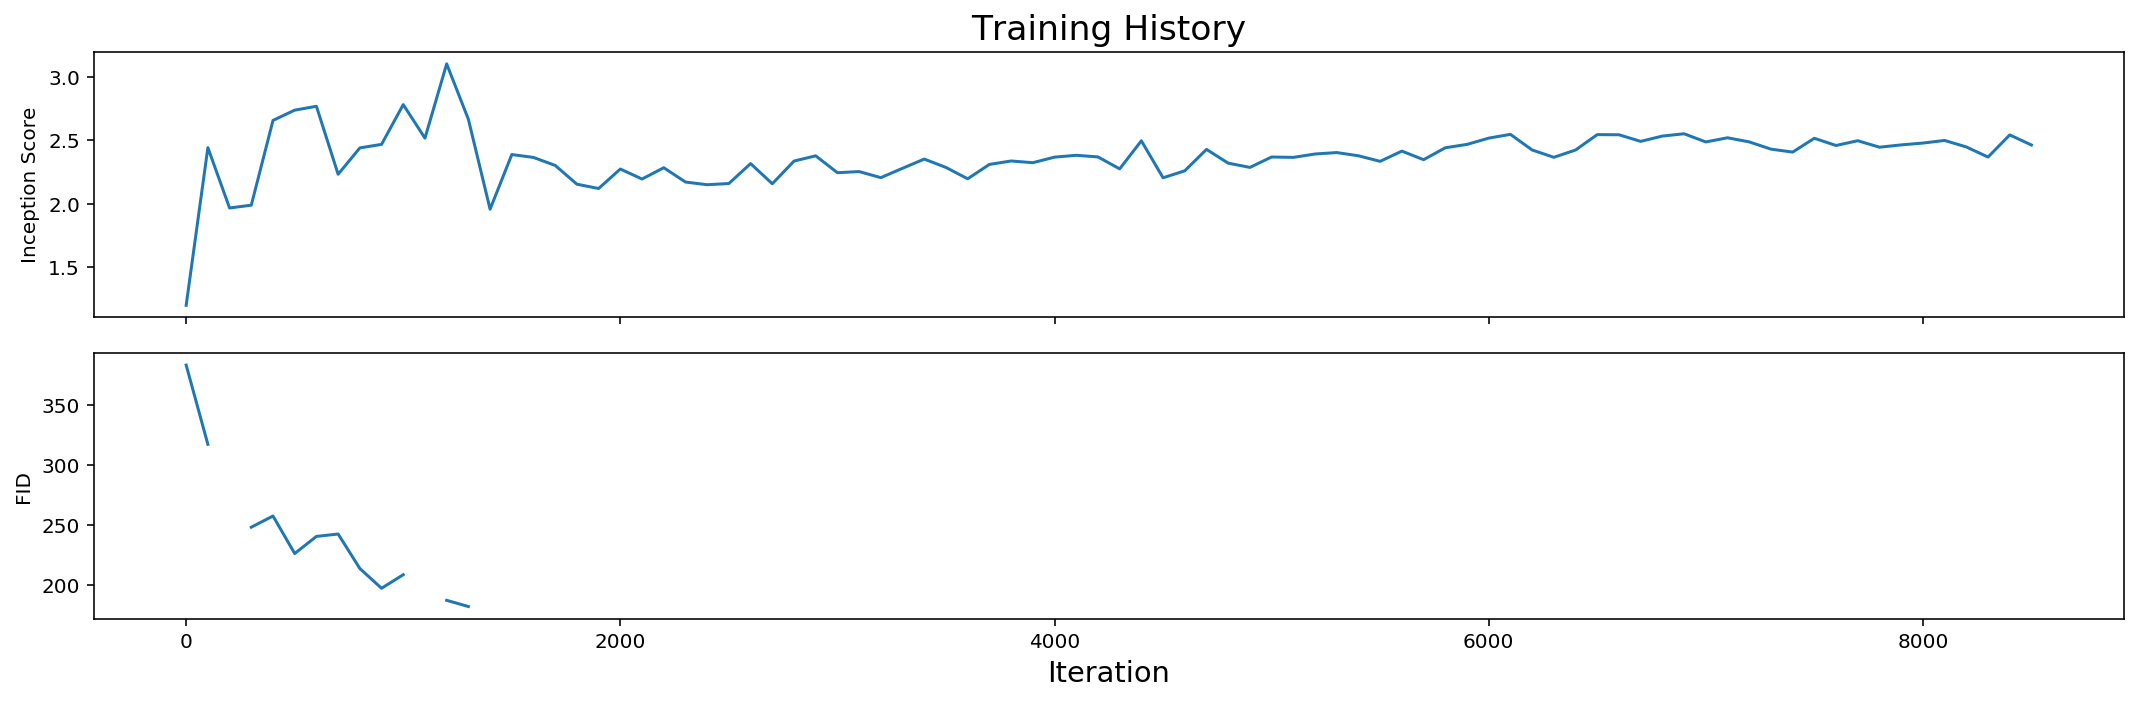

In [39]:
plot_loss_logs(G_losses, D_losses)
plot_metrics(IS_scores, FIDs)

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every `sample_every` iterations of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.


In [47]:
def make_training_video(samples_dir, resolution, num_rows=8):
    files = sorted([os.path.join(samples_dir, f) for f in os.listdir(samples_dir) if f.endswith('.jpg')])
    frames = [np.array(Image.open(f).convert('RGB'))[:num_rows * resolution] for f in files]
    clip = mpy.ImageSequenceClip(frames, fps=5)
    video_outfile = os.path.join(samples_dir, 'progress.mp4')
    clip.write_videofile(video_outfile)
    return video_outfile

video_outfile = make_training_video(os.path.join(samples_dir, model_name), resolution)
Video(video_outfile)

[MoviePy] >>>> Building video samples/dev_ema_cDCGAN_CelebA_64_bs256_dim_z100_G_ch64_D_ch64_G_lr0.0002_D_lr0.0002_G_betas0.5_0.999_D_betas0.5_0.999/progress.mp4
[MoviePy] Writing video samples/dev_ema_cDCGAN_CelebA_64_bs256_dim_z100_G_ch64_D_ch64_G_lr0.0002_D_lr0.0002_G_betas0.5_0.999_D_betas0.5_0.999/progress.mp4


100%|██████████| 86/86 [00:00<00:00, 157.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: samples/dev_ema_cDCGAN_CelebA_64_bs256_dim_z100_G_ch64_D_ch64_G_lr0.0002_D_lr0.0002_G_betas0.5_0.999_D_betas0.5_0.999/progress.mp4 



### Latent space exploration

The original DCGAN paper showed that the latent space learned by the generator maintains smooth transitions: as you walk through z space, the resulting output transistions naturally. Let's see if this holds for our generator.

In [ ]:
# Intra-class (z only) Latent space interpolation

num_samples = 8
num_midpoints = 8
minibatch_size = 8

# First, choose two random coordinates in z space.
z0 = torch.randn(num_samples, dim_z).to(device)
z1 = torch.randn(num_samples, dim_z).to(device)

# Interpolate between z0 and z1.
zs = vutils.interp(z0, z1, num_midpoints, device=device)
zs = zs.view(-1, zs.size(-1))

# Generate samples.
with torch.no_grad():
    samples = G(zs)

# Show
vutils.visualize_samples(samples, nrow=num_midpoints + 2)

## What's next !?

### Open source implementations
For some awesome open-source PyTorch implementations of recent GANs, check out:

- [BigGAN-PyTorch](https://github.com/ajbrock/BigGAN-PyTorch): Train BigGANs from *Large Scale GAN Training for High Fidelity Natural Image Synthesis* on 4-8 GPUs. Includes implementations for SN-GAN and SA-GAN as well!
- [pytorch_GAN_zoo](https://github.com/facebookresearch/pytorch_GAN_zoo): Implementations of DCGAN and Progressive Growing of GAN by Facebook Research.
- [pytorch-CycleGAN-and-pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix): Image-to-image translation in PyTorch (e.g., horse2zebra, edges2cats, and more)
- [PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN): Library of reference implementations (good for educational purposes).